# Building Micrograd

[Video](https://www.youtube.com/watch?v=VMj-3S1tku0)<br>
[Repository](https://github.com/karpathy/micrograd)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Goal](#Goal)
- [What is Micrograd](#What-is-Micrograd)
- [Problem Dissection](#Problem-Dissection)
    - [Understanding Derivatives](#Understanding-Derivatives)
    - [Derivatives in Neural Networks](#Derivatives-in-Neural-Networks)
        - [Value Class - Setup](#Value-Class---Setup)
        - [Value Class - Forward](#Value-Class---Forward)
        - [Value Class - Graph Generation](#Value-Class---Graph-Generation)
        - [Quick Recap](#Quick-Recap)
        - [Value Class - Setting up Backpropagation](#Value-Class---Setting-up-Backpropagation)
- [Neural Networks](#Neural-Networks)
    - [Manual Backpropagation](#Manual-Backpropagation)
    - [Automated Backpropagation](#Automated-Backpropagation)
        - [Value Class - Bug Hunting and Extending](#Value-Class---Bug-Hunting-and-Extending)
    - [Everything comes together](#Everything-comes-together)
- [Doing the exact same thing using the PyTorch API](#Doing-the-exact-same-thing-using-the-PyTorch-API)
- [Back to Neural Networks](#Back-to-Neural-Networks)

In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Goal

This course is about building and training neural networks from scratch, starting hands-on from the very basics, going all the way to implementing a fully functional GPT clone.<br>
For a start, we will walk through the [micrograd](https://github.com/karpathy/micrograd) project to explain the fundamentals of neural networks.<br>
We will cover the basics of what neural networks actually are, we will look at how they are trained and how they learn through what is called *backpropagation*.<br>
We will also use step-by-step examples throughout.

Let's start with the basics, what is [micrograd](https://github.com/karpathy/micrograd)?

> **Micrograd is an autograd engine (Automatic Gradient Engine).** It contains the essentials for training neural networks in just $150$ lines of code.<br>
> Notably, Micrograd implements **backpropagation** from scratch.<br>
> To make a neural network learn from data, *backpropagation* allows to iteratively tune the network's parameters such that they minimize the difference between the network's own prediction and a known reference value. In other words, *backpropagation* is what makes neural networks learn.

If all this sounds complicated, [don't worry about it](https://miro.medium.com/v2/resize:fit:1280/1*E4_pTJctmAofSRpZCZbv-g.jpeg).<br>
We will approach these concepts in due time, one by one, *from scratch*.

## What is Micrograd?

**Autograd engines are the core component for training neural networks.**<br>
Micrograd is a tiny autograd engine that supports automatic differentiation as well as higher-order gradient calculation.<br>
Consisting of around $150$ lines of Python code, it serves as an effective tool for understanding what autograd engines are, what they do and how they work.

Let's start with a simple example using the [original](https://github.com/karpathy/micrograd) Micrograd library:

In [2]:
from micrograd.engine import Value

# Create two "Value" objects, wrap two float numbers in them
a = Value(-4.0)
b = Value(2.0)

# Apply arithmetic operations on these "Value" objects
# Create a new "Value" object c and override it twice
c = a + b
c += c + 1
c += 1 + c + (-a)

# Prints -1.0
print(c.data)

# Apply Backpropagation
c.backward()

# Prints 3.0
print(a.grad)
# Prints 4.0
print(b.grad)

-1.0
3
4


**Micrograd allows you to define numeric values and apply arithmetic operations to these values, just as usual.**<br>
But, Micrograd additionally keeps track of the usages of each value as time progresses in a so-called **expression graph**.<br>
Finally, this built-up expression graph is traversed *backwards* to **compute the gradients** resulting from applied operations.<br>
The goal of autograd engines revolves around correctly, quickly and automatically computing the **gradients** for all kinds of arithmetic operations.

> **The gradient is a value that indicates the sensitivity of the final result to changes in the affecting values.**<br>
> If we know how much a change in a value affects the final result, we can adjust the value accordingly to shift the final result in the desired direction. This is the core concept behind **backpropagation**.

In the above code, `a` and `b` affect `c` through several different operations. After that, we run `c.backward()` to compute the gradients for `a` and `b` with respect to `c`. The gradients indicate the sensitivity of the final result `c` to changes in the affecting values `a` and `b`.<br>
For example, a small change in the initial value `b` would result in a $4.0 \times$ as large a change in the final result `c`.

The above example is very basic, but backpropagation can be applied for various arithmetic operations. With Multi-Layered Perceptrons (MLP), a subclass of neural networks, it's a bit more specific. There we have inputs and weights interacting with each other through matrix multiplication and addition.

> Starting from `c`, the gradient is calculated by recursively applying the [**chain rule**](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review) to all nodes in the expression graph that affect the value of `c`.


**But what does this mean?**<br>
**What is an expression graph? Why do we use expression graphs? How does the chain rule apply here?**<br>
Let's dissect the problem step by step.

## Problem Dissection

### Understanding Derivatives

If we want to derive the partial impact of contributing variables to some other variables, calculating derivatives is essential.<br>
**In fact, derivatives do exactly what we need here: They quantify the extent of changes in inputs affecting the outputs.**

Let's start slow; let's implement the arbitrary quadratic function $f(x) = 3x^2-4x+5$ in Python:

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5 # our arbitrary example function

f(3.0) # Prints 20.0

20.0

Let's also plot our example function:

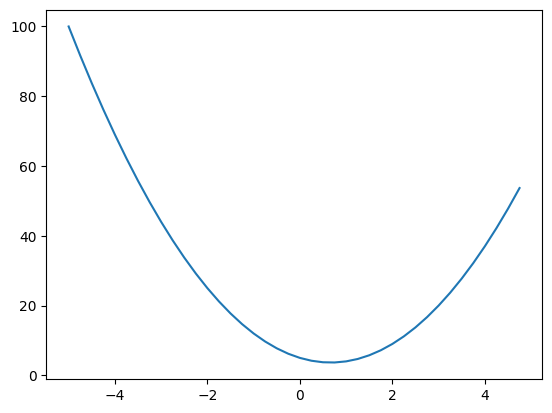

In [4]:
xs = np.arange(-5, 5, 0.25)  # Set of values from -5 to 5 with step 0.25
ys = f(xs)  # Applying f to each x
plt.plot(xs, ys);  # Plot y for each x

Now, what is the derivative at any point $x$ for our function $f(x)$?<br>
To go about solving this, we should first understand what the derivative is actually telling us about a function $f(x)$.

**This is the textbook definition of what it means to derive a function:**<br>
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

**What does this mean?**<br>
We're asked to add some positive value $h$ which is close to $0$ to our $a$ to see whether this 'nudge to $f(a+h)$' increases or decreases
the value returned by the function, compared to $f(a)$.<br>
If the function increases, the derivative is positive. If the function decreases, the derivative is negative.

We implement this *verbatim*:

In [5]:
h = 0.00000001
x = 3.0

# Approximate derivative of f at x=3
print((f(x+h)-f(x))/h)

14.00000009255109


This result tells us that the derivative of $f$ with respect to $x$ at $x=3$ is $m \approx 14$.<br>
(Calculus taught us that the derivative of $f(x) = 3x^2-4x+5$ is $f'(x) = 6x-4$, and $f'(3) = 14$, but we act strictly on the definition here.)

Let's increase the complexity with $3$ inputs and $1$ output:

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


Given the code above, `d = a * b + c` is still a function.<br>
You may think at a first glance that this function feels 'simpler' than the quadratic function from before,<br>
but what is the derivative of `d` with respect to `a`, `b` and `c`?

Let's *again* take the verbatim approach:

In [7]:
h = 0.00001

# This is the point (a, b, c) 
# for which we want the derivative of d
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # function value at (a, b, c)

a += h       # bump up a by h
d2 = a*b + c # function value at (a+h, b, c)
a -= h       # restore a

b += h       # bump up b by h
d3 = a*b + c # function value at (a, b+h, c)
b -= h       # restore b

c += h       # bump up c by h
d4 = a*b + c # function value at (a, b, c+h)

print('Function value for (a,b,c) d1:\t', d1)
print()
print('Function value for (a+h,b,c) d2:', d2)

# How much the function increased from bumping up a
print('slope', (d2 - d1)/h)
print('\nFunction value for (a,b+h,c) d3:', d3)
# How much the function increased from bumping up b
print('slope', (d3 - d1)/h)
print('\nFunction value of (a,b,c+h) d4:\t', d4)
# How much the function increased from bumping up c
print('slope', (d4 - d1)/h)

Function value for (a,b,c) d1:	 4.0

Function value for (a+h,b,c) d2: 3.9999699999999994
slope -3.000000000064062

Function value for (a,b+h,c) d3: 4.00002
slope 2.0000000000131024

Function value of (a,b,c+h) d4:	 4.00001
slope 0.9999999999621422


These modified functions tell us how the value of the original function changes with respect to each individual input value.<br>
**This is the partial derivative of the function with respect to either `a` ($d2$), `b` ($d3$) or `c` ($d4$).**

> **The partial derivative tells us how a function output changes in relation to a change in either of its inputs.**

### Derivatives in Neural Networks

#### Value Class - Setup

We want to move the logic of derivatives over to neural networks.<br>
To achieve this, we require suitable data structures.

The class `Value` takes a single numeric value and keeps track of it.<br>
You can define values like `a = Value(3.0)` and `b = Value(-2.0)`,<br>
but you then should also be able to perform `a + b` or `a * b` in order to construct a graph of operations.<br>
And from this, we should be able to find the derivative of the final result with respect to the initial values.

In [8]:
class Value:
    
    # Object initialization
    def __init__(self, data):
        self.data = data

    # Tells how to print this object nicely  
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c # this really is: a.__mul__(b).__add__(c)

print(d) # Value(data=4.0)

Value(data=4.0)


#### Value Class - Forward

Data storage and presentation as well as multiplication and addition are accounted for.<br>
What we are still missing now is a structure for knowing which operations were applied, what the order of application was and which connections between `Value` objects were made along the way.<br>
**Put differently, we want to record *how* specific `Values` produce other `Values`.**

To add this tracking capability, we extend `Value` by an attribute `_children`.<br>
`_children` is an empty tuple that internally is stored as a `set` (this conceptual switch from tuple to set is just for performance)

> The `_children` attribute is a set of `Value` objects that influences the current `Value` object directly. For `c = a + b`, `c` would have `a` and `b` in its `_children` set.

You might ask yourself why we call the attribute `_children` and `_prev` and not `_parents` and `_prev`. It's a design choice, but I assure you it's not a mistake.<br>
The reason is that later we will traverse the graph backwards, from the result to the inputs. So, what technically now seems to be the parents will then seem to be the children.

In [9]:
class Value:
    
    # This got extended to take in _children
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        # We initialize the result's _children to be self and other
        out = Value(self.data + other.data, (self, other))
        return out
    
    # Multiplication
    def __mul__(self, other):
        # We initialize the result's _children to be self and other
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

d # Value(data=4.0)
d._prev # {Value(data=-6.0), Value(data=10.0)}

{Value(data=-6.0), Value(data=10.0)}

We now know the immediate prior values, the children, but we don't know *how* `d` was created *with* these values.<br>
To achieve this, we extend our `Value` class further.<br>
Also added is a label attribute for the graph generation down below. This is purely for visualization purposes.

In [10]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-2.0), Value(data=4.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


#### Value Class - Graph Generation

We can now track that `d` was produced by the addition of two values `e` and `c`.<br>
More generally, we can follow which `Value` was created from which and how that was done, like in a tree making up a final solution node.

**Ideally, we'd like to have a way of visualizing our expression graph.**

The code for that looks a bit scary:

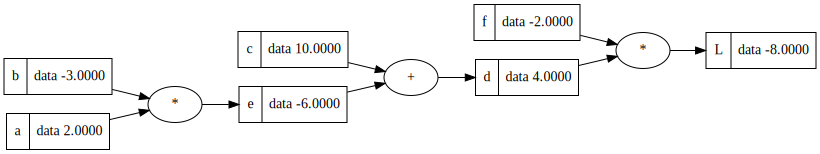

In [11]:
from graphviz import Digraph

# Enumerates all the nodes and edges -> builds a set for them
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Draw the graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

---

### Quick Recap

So far,<br>
- we can **build mathematical expressions** with $+$ and $*$, 
- we can **keep track of what `Value` objects are interconnected through what operations**, resulting in a new `Value`
- we can **visualize the expression graph** associated to a resulting `Value`

> Currently, we only visualize the **forward pass**.

Next, we need to also cover **backpropagation**.

---

#### Value Class - Setting up Backpropagation

Let's stick with the above example of how `L` was created.<br>
We start with the *forward pass* result (meaning `L`). Then, in reverse, we walk along the dependency tree calculating the gradient for the intermediate values.

> In essence, per node, we calculate the derivative of `L` with respect to this node.

The derivative of `L` with respect to `L` is $1$. Easy, but what's the derivative of `L` with respect to `f` and so on?<br>
The derivative of one value (like `L`) with respect to another value that contributes to it (like `f`) is called the **partial derivative**, also known as the **gradient**.

> The **gradient** is the derivative of the loss function with respect to the current `Value`.

For every `Value` the derivative is set to `0` by default. This will be modified accordingly for every mathematical interaction in the dependency tree that it participates in.

In [12]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # This is how we want to print this object
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    # Tanh function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        return Value(t, (self, ), 'tanh')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-2.0), Value(data=4.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=4.0), Value(data=-2.0)}
*


Let's see what this looks like in the graph:

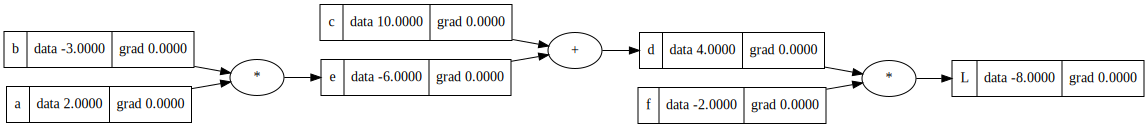

In [13]:
# Enumerates all the nodes and edges -> builds a set for them
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Draw the graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

In this dependency tree graph structure we have a field per node to store the backpropagated value.<br>
But calculation and accumulation of the gradients is still missing.

Let's play with this idea first:

In [14]:
# This is just always the case
L.grad = 1.0

# As L = d * f is given we're certain that dL/dd = f
d.grad = f.data

# and therefore this is also true
f.grad = d.data

So far, so good.<br>
**Let's get to the crux of backpropagation.**

> **If you get the next part, you will also get how training neural networks works on a fundamental level.**

Let's introduce some mathematical notation.<br>
Say, we need to determine the partial derivative of $L$ with respect to $c$, or $\frac{\partial L}{\partial c}$.<br>
Let's also say that we stick to the example from above, meaning:
- $e = a \times b$
- $d = e + c$
- $L = d \times f$

For our example, we assume this is **known already:** $\frac{\partial L}{\partial d} = -2.0$

I'll go ahead and claim that just from this setting, we can directly say that the *local derivative* of $c$ and $e$ is $1$, respectively.<br>
**How? Why? What?** Well, the term *local derivative* refers to the immediate operation within which the terms $c$ and $e$ are used: $d = c + e$.<br>
Intuitively, a change of a particular size to $c$ or $e$ impacts $d$ with the exact same size.<br>
Therefore the *local derivative*, the 'impact factor' so to say, is $1$ for both $c$ and $e$.

$\frac{\partial d}{\partial c} = 1.0$<br>
$\frac{\partial d}{\partial e} = 1.0$

As our goal is to find $\frac{\partial L}{\partial c}$, we need to *somehow* concatenate the known intermediary result $\frac{\partial L}{\partial d}$<br>
with our local derivative $\frac{\partial d}{\partial c}$ to formulate $\frac{\partial L}{\partial c}$ across both of them.

> **That looks like a job for the chain rule!**

The chain rule looks like this:<br>
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a610aa8446be002e2e30d7121f6a87273d4caa)

Curiously, the $\frac{\partial d}{\partial c}$ turns out to have no effect on the final result $\frac{\partial L}{\partial c}$, as it's $1.0$.

> As the addition node's *local derivatives* are $1.0$, addition basically routes the gradient equally down to the values that were summed.<br>
In other words, addition evenly distributes the gradient we accumulated until that point to the summands.

$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} * \frac{\partial d}{\partial c} = \frac{\partial L}{\partial d} = \frac{\partial L}{\partial e} = \underline{\underline{-2.0}}$

Stepping further into the dependency tree, $e$ is made up of $a$ and $b$ through $e = a \times b$.<br>
We have to deal with multiplication now.<br>

Above, we learnt that $\frac{\partial L}{\partial e} = -2.0$.<br>
Now, again, we start by formulating the *local derivatives*: $\frac{\partial e}{\partial a}$ and $\frac{\partial e}{\partial b}$.

From looking at $e = a \times b$, we can see that $\frac{\partial e}{\partial a} = b = -3.0$ and $\frac{\partial e}{\partial b} = a = 2.0$.

> The scale by which either of two factors affects the result is defined by the other factor.

We can use the chain rule again to calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$:<br>
$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \times \frac{\partial e}{\partial a} = -2.0 \times -3.0 = \underline{\underline{6.0}}$<br>
$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \times \frac{\partial e}{\partial b} = -2.0 \times 2.0 = \underline{\underline{-4.0}}$

Combined with the gradients for `c` and `e`, this is the updated graph:

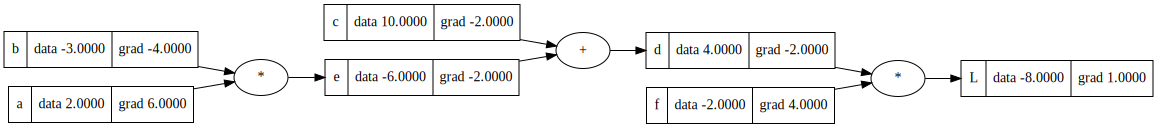

In [15]:
# Gradients of sum
c.grad = d.grad * (1) # dL/dc = dL/dd * dd/dc = dL/dd * 1
e.grad = d.grad * (1) # dL/de = dL/dd * dd/de = dL/dd * 1

# Gradients of multiplication
a.grad = e.grad * b.data # dL/da = dL/de * de/da = dL/de * b
b.grad = e.grad * a.data # dL/db = dL/de * de/db = dL/de * a

draw_dot(L)

Let's look at how `L` changes when updating the contributing variables by their gradient:

In [16]:
# Moving leaf nodes in gradient direction
# This is gradient ascent (not descent)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Forward pass
e = a * b
d = e + c
L = d * f

print(L.data) # L increased

-7.286496


**Why did we see an increase of `L`?**

The gradient always points in the direction of the **steepest ascent**.<br>
<br>
Moving a value in that direction will provide a biggest possible effect of increase on the final result `L` through this value.<br>
Moving all values in gradient direction maximizes `L`.<br>
Moving all values in the exact opposite/negative direction of this gradient therefore minimizes `L`.

## Neural Networks

Let's take the concepts of forward pass and backpropagation and apply them to neural networks.

Eventually, we want to build working neural networks (NNs):<br>
![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

We can utilize the mathematical model for what a neuron in such a neural network looks like:<br>
![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

The activation function used here is `tanh`.<br>
For reference, here's what `tanh` and `sigmoid` (another activation function) look like:

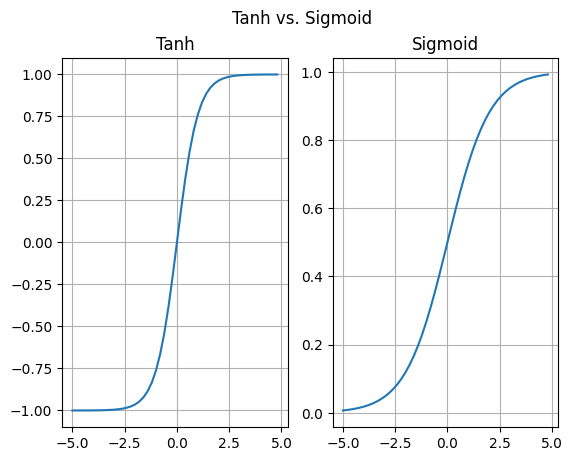

In [17]:
def sigmoid(x):
    a = []
    for i in x:
        a.append(1/(1+math.exp(-i)))
    return a

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Tanh vs. Sigmoid')

lower = -5
upper = 5
step = 0.2

ax1.grid()
ax1.set_title('Tanh')
ax1.plot(np.arange(lower, upper, step), np.tanh(np.arange(-5, 5, 0.2))) # Tanh activation function
ax2.grid()
ax2.set_title('Sigmoid')
ax2.plot(np.arange(lower, upper, step), sigmoid(np.arange(-5, 5, 0.2))) # Sigmoid activation function (alternative)

plt.show();

The `tanh` function's range is $[-1,1]$, while the `sigmoid` function's range is $[0,1]$.<br>
Per iteration, for our specific case, `tanh` will produce rather more precise gradients, leading to more efficient training cycles. 

**Don't generalize this notion, though.**

Let's go ahead and build a tiny MLP just by implementing $\text{tanh}(\sum_{i=1}^{n} w_ix_i + b)$ for $n=2$:

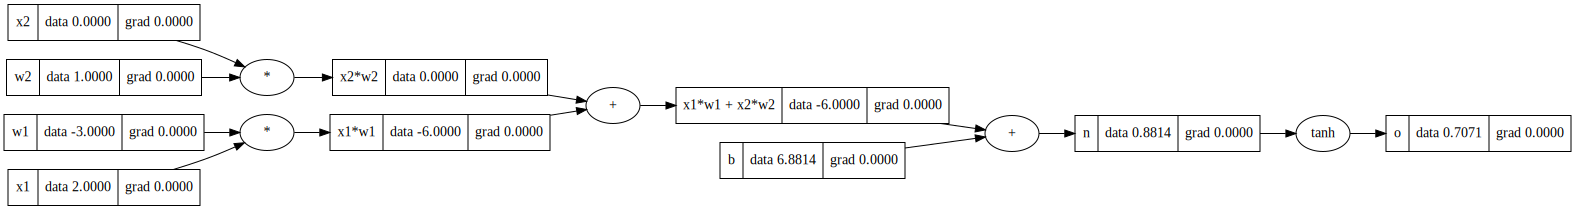

In [18]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
# Making sure backprop numbers come out nice later on
b = Value(6.8813735870195432, label='b')

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n)
o = n.tanh(); o.label='o'

draw_dot(o)

### Manual Backpropagation

We laid out the ground rules to backpropagation before.
But now, let's perform actual manual backpropagation for this setup: Starting from `o` and going backwards, we want to find all the gradients.

> By the end, we can ideally answer "What is the derivative of `o` with respect to `x1, w1, x2, w2`?"<br>These are the variables we can directly change and therefore care about the most.

The gradient of the activated result `o` is $1.0$, as always. But what about the gradient of `n`, i.e. $\frac{\partial o}{\partial n}$?

The local derivative of `tanh` is $1 - \text{tanh}^2(n)$.<br>
With that defined, we can go back(wards) to the future:

In [19]:
# Always a given
o.grad = 1.0

# o = tanh(n), what is do/dn?
# do/dn = 1 - tanh(n)**2
n.grad = 1 - o.data**2

# As addition "just" splits the gradient
x1w1x2w2.grad = n.grad
b.grad = n.grad

# And addition again
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# And multiplication handles like in the example above
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data # This will be 0: Changing this value does nothing, as its multiplied by 0

### Automated Backpropagation

**Doing backprop manually is amateur-hour.** We should automate and generalize this. 

To do so, we need to re-write/extend the `Value` class.<br>
To be more precise, we need to extend the `Value` object by a `_backward` attribute, a [lambda expression](https://www.bomberbot.com/python/lambda-expressions-in-python-a-comprehensive-guide/) initialized with `None`.<br>
For each operation, `_backward` is populated with a concrete gradient calculation step.


The code below realizes the above concept really beautifully:

In [20]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Route gradient to parents
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out
     
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # Route gradient affected by data of other node
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        
        out._backward = _backward
        return out
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # Local derivative times gradient of child node
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-2.0), Value(data=4.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=4.0), Value(data=-2.0)}
*


Let's now build a simple MLP and 'forward pass' through it:

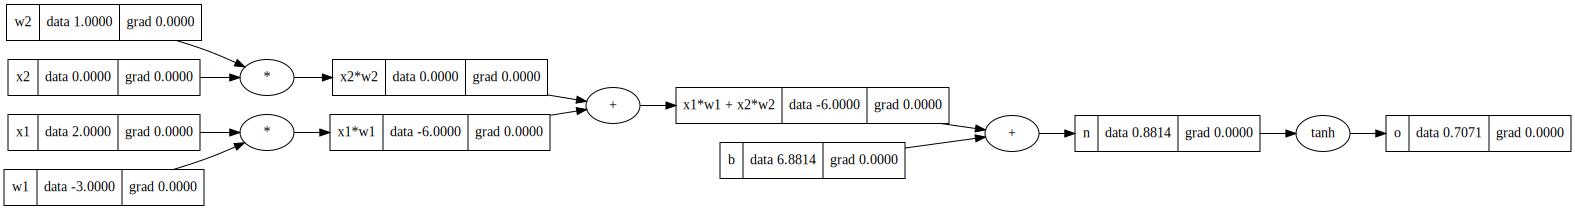

In [21]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Forward Pass 
# Goal: Find the value of the single output neuron 'n'
# Neuron value n = x1*w1+x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation: tanh(n)
o = n.tanh(); o.label='o'

draw_dot(o)

We don't have to perform backpropagation manually anymore (except for `o.grad`, please ignore that and keep the exact order of operations in mind):

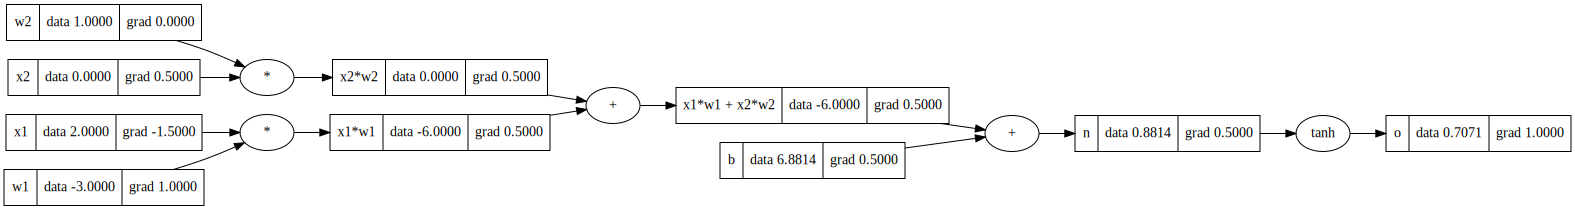

In [22]:
o.grad = 1.0  # Base case for backprop multiplication to work
o._backward()
n._backward()
b._backward() # Nothing happens, as this is a leaf
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

**We now have one last thing to get rid of:** Having to call `_backward()` manually in the particular order (one after another, backwards) on our nodes.

Going backwards through our expression graph means that for every node everything following it has to be already calculated.<br>
This requires ordering. Ordering graphs can be done using **topological sort**.<br>
This arranges the nodes of our dependency graph so that edges always point in *one common direction*:<br><br>
![](https://assets.leetcode.com/users/images/63bd7ad6-403c-42f1-b8bb-2ea41e42af9a_1613794080.8115625.png)

The ordering from topological sort guarantees that gradients are computed and propagated in a manner that avoids redundant computations and maximizes computational parallelism, resulting in improved efficiency through seamless flow of gradients through the network and thus accelerated convergence rates. [Read More...](https://www.geeksforgeeks.org/topological-sorting/)

In [23]:
# Topological sort
# Structuring our graph so that we can traverse in dependency-respecting order

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Only add node if all preceeding nodes were processed first
build_topo(o)

for t in topo:
    print(t)

Value(data=6.881373587019543)
Value(data=1.0)
Value(data=0.0)
Value(data=0.0)
Value(data=2.0)
Value(data=-3.0)
Value(data=-6.0)
Value(data=-6.0)
Value(data=0.8813735870195432)
Value(data=0.7071067811865476)


This is the exact order by which we need to apply `_backward()` to our graph, starting from `o`.

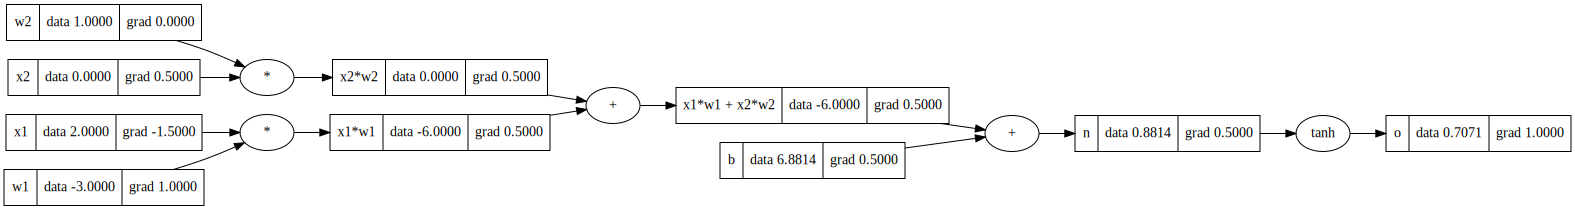

In [24]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Only add node if all nodes were processed first
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

We now go on and implant this logic into our `Value` class.<br>
**This is the new class structure:**

In [25]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        
        out._backward = _backward
        return out
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Add this node if all children were processed first
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

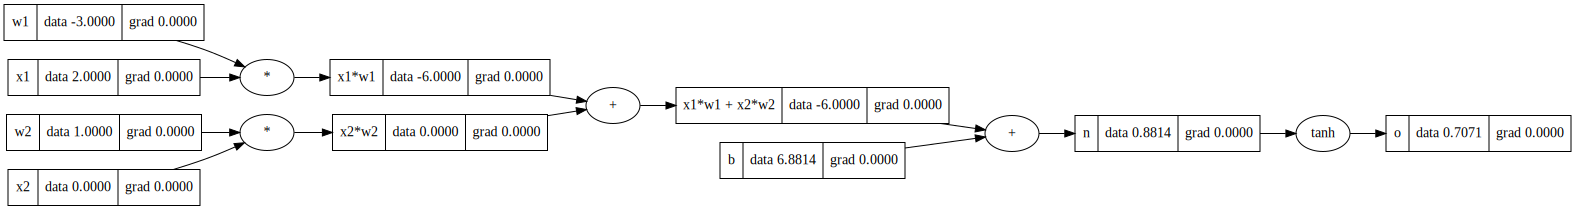

In [26]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Forward Pass
# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n)
o = n.tanh(); o.label='o'

draw_dot(o)

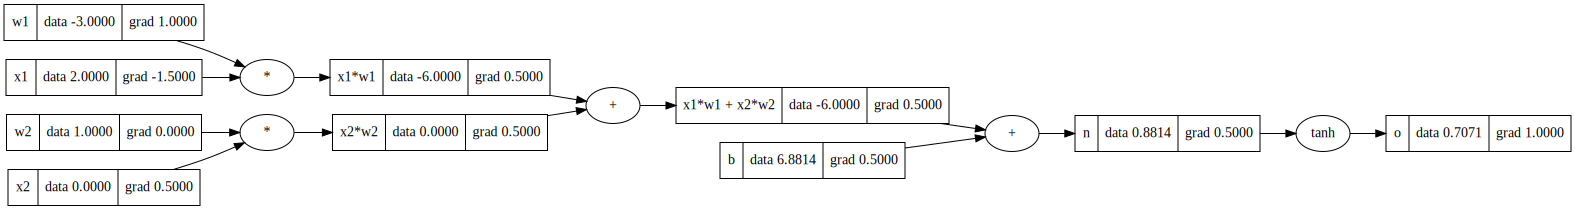

In [27]:
o.backward()
draw_dot(o)

#### Value Class - Bug Hunting and Extending

We built backpropagation. At least for *one* neuron `o`.<br>**But we still have a bug.** 

The bug emerges here:

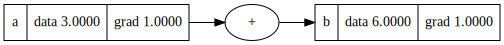

In [28]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

Even though we apply addition the gradient should be $2$, because `a + a` is the same as `2 * a`.<br>
The faulty behavior persists here too:

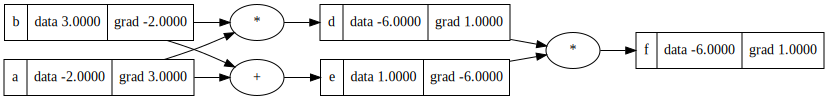

In [29]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

**We have a problem as soon as a variable is used more than once.**<br>
But this is the case most of the time in real-world examples.

> **We actually need to *accumulate* the gradients (`+=`) rather than *setting/overriding* them (`=`)**.

Also, while we're at it, let's extend the `Value` class further.<br>
For example, we can't do `a = Value(2.0) + 1.0` or `a = Value(2.0) * 2.0`.<br>
And also, let's access division and the detail operations behind `tanh` now.

A fixed and extended version of the `Value` class looks like this (see the backward-functions for the `+=` bugfix):

In [30]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Extension
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad  # Bugfix
            other.grad += 1.0 * out.grad # Bugfix
        
        out._backward = _backward
        return out
    
    # Negation (special multiplication)
    def __neg__(self): # -self
        return -1 * self
    
    # Subtraction (special addition)
    def __sub__(self, other): # self - other
        return self + (-other)
 
    # Multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Extension
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data # Bugfix
            other.grad += out.grad * self.data # Bugfix
        
        out._backward = _backward
        return out
    
    # Power (special multiplication)
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers (for now)"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    # Called if self is on right side of *
    def __rmul__(self, other): # other * self
        return self * other
    
    # Called if self is on right side of +
    def __radd__(self, other): # other + self
        return self + other
    
    # True division (special multiplication)
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # Bugfix
        
        out._backward = _backward
        return out
    
    # Exponential function
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Only add node if all nodes were processed first
        build_topo(self)
        
        self.grad = 1.0 # Seed gradient always 1.0
        
        for node in reversed(topo):
            node._backward()

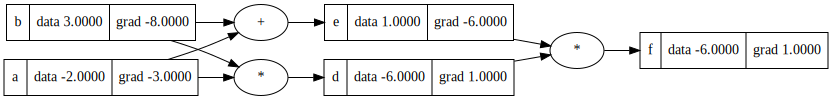

In [31]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

In [32]:
# Just a sanity check for the newly implemented arithmetics

a = Value(2.0)
b = Value(4.0)

print(a + 2)
print(2 + a)
print(a * 2)
print(2 * a)
print(-a)
print(a - b)

print(a.exp())
print(a / b) # Division: a/b = a * (1/b) = a * (b**(-1)), so we use a function realizing x**k

Value(data=4.0)
Value(data=4.0)
Value(data=4.0)
Value(data=4.0)
Value(data=-2.0)
Value(data=-2.0)
Value(data=7.38905609893065)
Value(data=0.5)


### Everything comes together

We will now change the example from above.<br>
More precisely, we will change how we define `o` using the now available, more detailed forward and backprop operations for `tanh`.

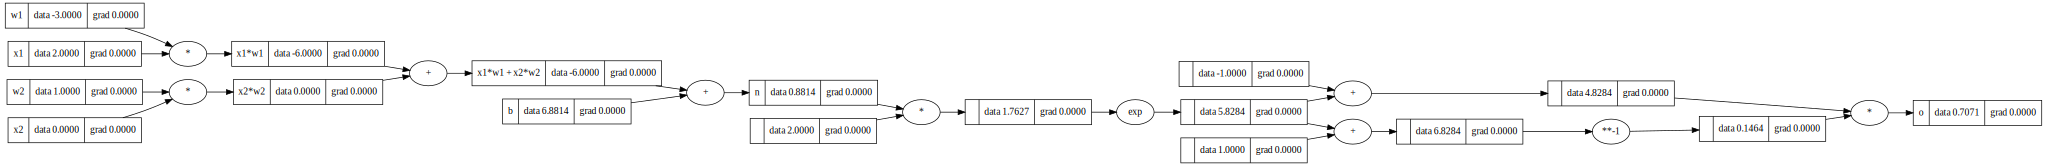

In [33]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n) NOW EXPLICITLY IMPLEMENTED
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label='o'

draw_dot(o)

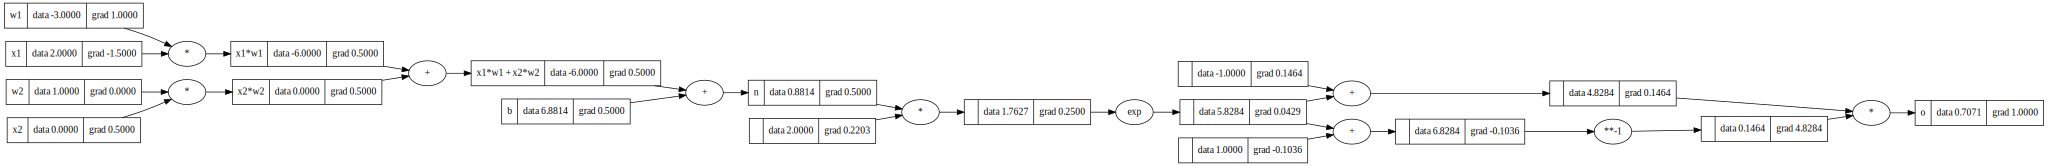

In [34]:
# The x1, x2,... gradients should remain the same
o.backward()
draw_dot(o)

**Why did we do what we just did**?<br><br>
We essentially went ahead and changed the level of implementation in this run.<br>
It is up to us if we want to just implement one `tanh` or if we go on and implement that function's atomic steps explicitly.<br>
This in essence was training on how to deal with operations, with zooming in and out of an implementation approach and with new gradient calculations necessary for the necessary steps.

---

## Doing the exact same thing using the PyTorch API

The [original micrograd](https://github.com/karpathy/micrograd) is modeled roughly after the PyTorch syntax. In fact, it can just as well be implemented in PyTorch.<br>
This might seem a bit messy at first though, as it requires values to be stored in PyTorch's Tensor objects.

In [35]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True  # single element tensors
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True  # tensor datatype is now double
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True  # default dtype was float32
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True  # now its float64 aka double
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b # perform arithmetic just like with micrograd
o = torch.tanh(n)

print(o.data.item())
o.backward() # backward() is pytorch's autograd function

print('---') # These values below are just like micrograds left most layer
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [36]:
o.item() # Pluck out the scalar value from tensor o

0.7071066904050358

> The big deal about being able to use PyTorch is that it makes processing **significantly more efficient** through a bunch of optimizations under the hood.

## Back to Neural Networks

Now that we have some vehicles to build complex mathematical expressions, we can build layered NNs.<br>
We'll do that piece by piece and end up with a 2-layer multi-layer perceptron (MLP).

In theory, we can say that the output of micrograd's forward pass can be interpreted as the activation of a neuron.<br>
Therefore we can build a neuron taking in and processing some input. But we will now do so utilizing the powers of PyTorch.

For the sake of completeness, here is the schematic for an NN again:<br>
<br>
![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [37]:
# One neuron is able to take multiple inputs and produce one activation scalar
class Neuron:
    def __init__(self, nin):
        # nin -> number of inputs to this neuron
        # Random weight [-1, 1] per input
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        # Bias controls general "trigger happiness" of neuron
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self, x): # running neuron(x) -> __call__ triggered
        # w * x + b
        # zip() creates iterator running over the tuples of two iterators
        # self.b is taken as the sum's start value and then added upon
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # Squash the activation with tanh
        out = act.tanh()
        return out
    
    # Convenience code to gather the neuron's parameter list
    def parameters(self):
        return self.w + [self.b]


# A set of neurons making up a (hidden/input/output) NN layer
# E.g. n = Layer(2, 3) -> 3 2-dimensional neurons
class Layer:
    # nout -> how many neurons/outputs should be in this layer
    # nin -> how many inputs are to be expected per neuron
    def __init__(self, nin, nout):
        # literally create a list of neurons as needed
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x): # running layer(x) -> __call__ triggered
        # return all of the layer's neuron activations
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    # Convenience code to gather all parameters of layer's neurons
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


# MLP -> Multi-layer perceptron -> NN
class MLP:
    # nin -> number of inputs to the NN
    # nouts -> list of numbers, defines sizes of all wanted layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x): # mlp(x) -> call all layer(x)s values in NN
        for layer in self.layers:
            # Neat forward pass implementation
            x = layer(x)
        return x
    
    # Convenience code to gather all parameters of all layer's neurons
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [38]:
x = [2.0, 3.0, -1.0]  # input values
n = MLP(3, [4, 4, 1]) # 3 inputs into 2 layers of 4 and one output layer
print(n(x))

Value(data=-0.4627577841060699)


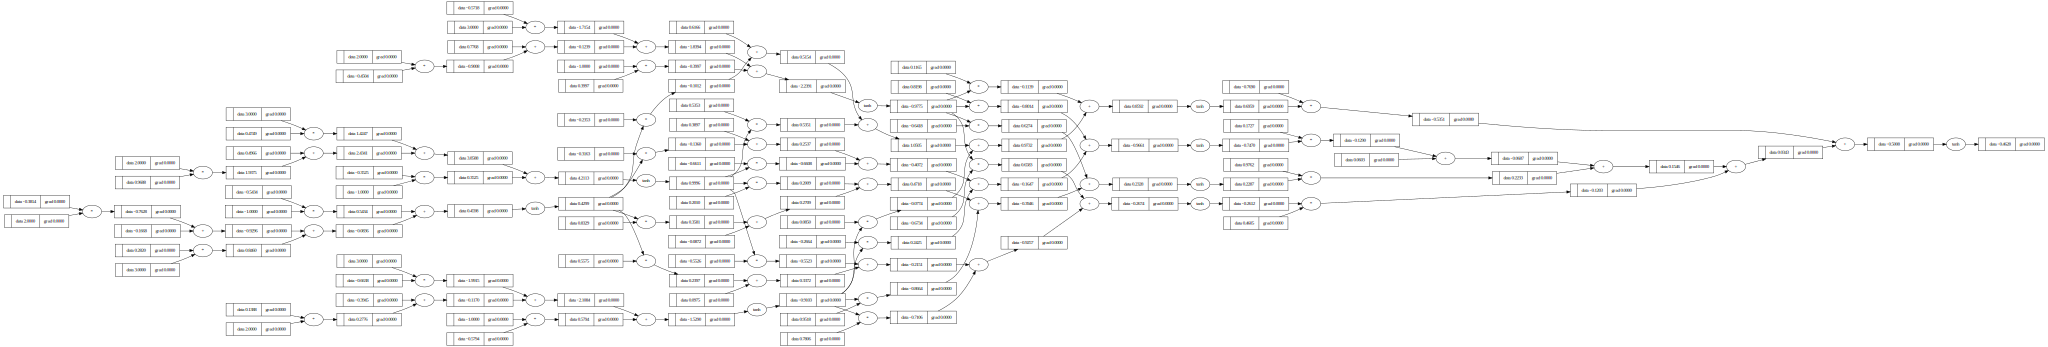

In [39]:
draw_dot(n(x))

With micrograd, we are now able to relatively easily backpropagate through this mess.<br>
**Let's do that, let's define an example training set with features and labels.**

In [40]:
# Features/Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0]

# Get the NN's current prediction for xs
ypred = [n(x) for x in xs]

for i in range(len(ypred)):
    print(f'{ypred[i]}\t --> {ys[i]}')

Value(data=-0.4627577841060699)	 --> 1.0
Value(data=-0.8692127471133085)	 --> -1.0
Value(data=-0.9450451019760748)	 --> -1.0
Value(data=-0.3291139870213737)	 --> 1.0


**The neural network doesn't perform very well at this point. That's because it is untrained.**<br>
We need to measure how good/bad the neural network performs to make steps towards improving its performance. 

**We need a loss function** to measure just how good/bad predictions are.

In [41]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print('loss:', loss.data)

loss: 3.9263296717932197


This loss now has to become as low as possible.<br>
If loss is low, the predictions more closely resemble the expectations provided through the labels.

In [42]:
loss.backward()

In [43]:
# Example neuron weight with now calculated gradient
print(n.layers[0].neurons[0].w[0].grad) # First layer's first neuron's first weight's gradient
print(n.layers[0].neurons[0].w[0].data) # First layer's first neuron's first weight's value

-6.2178271092591775
-0.3814047260811313


In [44]:
# Weight Update with Backpropagation's gradients
for p in n.parameters(): 
    p.data += -0.01 * p.grad # Move a tiny bit in opposite direction of gradient to not overfit this single example

In [45]:
# Show updated weight
print(n.layers[0].neurons[0].w[0].data)

-0.3192264549885395


Ok. We have a loss function as a way to measure how well the neural network performs.<br>
The `loss` term is directly linked to the parameters, the activated weights and biases of the MLP.<br>
If we calculate the gradients, we determine the strength and direction<br>
of the changes we would need to make to the weights and biases to *maximize* the loss. 

Yes, *maximize*.

That's exactly what we don't want here, though.<br>
We want to *minimize* the loss. To do so, wenegate the gradients and scale them by a factor of $0.01$.<br>
Changing all parameters by nudging them in the opposite direction of the gradients<br>
by a small amount *and only a small amount* avoids over-adapting to what individual inputs desire the weights to be.<br>
This process is called **gradient descent** and it is used for training neural networks.


**Congratulations, you just learned how to build and train a neural network from scratch!**

*One more thing.*

Training most often is not done by exposing the network once to the data points,<br>
but by doing so multiple times. One such iteration through the dataset during training is called an **epoch**. 

We will now train the network for $5$ epochs:

In [46]:
# Run epochs and show respective predictions
for t in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    print(f'Epoch {t}\t - Loss: {loss.data}\t - Predictions: {[y.data for y in ypred]}')

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters(): 
        p.data += -0.01 * p.grad

Epoch 0	 - Loss: 1.4732636974758586	 - Predictions: [0.12051446615576634, -0.8069211590344205, -0.9325101231357197, 0.1888683393389119]
Epoch 1	 - Loss: 0.797243440925359	 - Predictions: [0.36969995560610736, -0.7693694624145316, -0.9261349510881474, 0.41577503935153254]
Epoch 2	 - Loss: 0.5634161368982445	 - Predictions: [0.48458958597572965, -0.7561410114296612, -0.9234329677255118, 0.5178812124842016]
Epoch 3	 - Loss: 0.44276598489886565	 - Predictions: [0.5541625535379207, -0.7544754830719079, -0.92218313620927, 0.5785059863674927]
Epoch 4	 - Loss: 0.36731012321919027	 - Predictions: [0.6021283734506431, -0.7584931804524524, -0.9216602117319308, 0.6198084355324257]
Epoch 5	 - Loss: 0.31472877474663363	 - Predictions: [0.6378289499149304, -0.7651458239014687, -0.9215389246789439, 0.6503597836983633]
Epoch 6	 - Loss: 0.27558025897239974	 - Predictions: [0.6657756505075203, -0.7728346720107504, -0.921650989676584, 0.6742214102805305]
Epoch 7	 - Loss: 0.2451338266506941	 - Predictions:

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>

In [47]:
ypred

[Value(data=0.7233637371440259),
 Value(data=-0.7957583011431),
 Value(data=-0.9226251368414703),
 Value(data=0.7235142566533981)]